# Acquire and Prep - Wrangle

What is special about preparing data for linear regression?

- Linear Assumption: Possibly transform data to make the relationship linear (e.g. log transform for an exponential relationship).
- For additional info: https://setosa.io/ev/ordinary-least-squares-regression/
- Remove Noise/Outliers: Most important for the output variable and you want to remove outliers in the output variable (y) if possible.
- Remove Collinearity. Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
- Gaussian Distributions. Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution.
- Rescale Inputs: Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

In the following lessons, we will walk through the data science pipeline using the following scenario:

I'm a university teacher, and I want to know when to worry about a student's progress.  I want to be able to work with any students who are at high risk of failing the class, so that I can try to prevent that from happening.  I have the grades of the three exams and the final grade from last semester's class.  I'm hoping I can build a prediction model that will be able to use these exams to predict the final grade within 5 points average per student.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from env import host, user, password

## Acquire the Data

Let's use pandas to read our csv into a pandas DataFrame.

In [2]:
# Read csv file into pandas DataFrame.
file = "https://gist.githubusercontent.com/ryanorsinger/14c8f919920e111f53c6d2c3a3af7e70/raw/07f6e8004fa171638d6d599cfbf0513f6f60b9e8/student_grades.csv"
df = pd.read_csv(file)

### Sample and Summarize

Let's take a look at the DataFrame we brought in and document our initial findings.

In [3]:
df.head()

,student_id,exam1,exam2,exam3,final_grade
0,1,100.0,90,95,96
1,2,98.0,93,96,95
2,3,85.0,83,87,87
3,4,83.0,80,86,85
4,5,93.0,90,96,97


In [4]:
# 104 rows and 5 columns coming in.

df.shape

(104, 5)

In [5]:
# Display readable summary statistics for numeric columns. Why isn't exam3 showing up?

df.describe().T

,count,mean,std,min,25%,50%,75%,max
student_id,104.0,52.500000,30.166206,1.0,26.75,52.5,78.25,104.0
exam1,103.0,78.621359,14.260955,57.0,70.00,79.0,92.00,100.0
exam2,104.0,77.307692,10.295703,65.0,70.00,75.0,89.00,93.0
final_grade,104.0,81.692308,10.918122,65.0,72.00,81.0,93.00,97.0


In [6]:
# Running .info() shows us that the exam3 column is not a numeric data type; it's an object.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   student_id   104 non-null    int64  
 1   exam1        103 non-null    float64
 2   exam2        104 non-null    int64  
 3   exam3        104 non-null    object 
 4   final_grade  104 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.2+ KB


#### Acquire and Summarize Takeaways

- Need to change the datatype of exam3
- Drop the studentid
- Why is exam1 reading in as a float
- Why does exam1 have 1 fewer value than everything else
- Why is exam3 an object dtype?

___

## Prepare the Data

### Finding Null Values

Let's check out some other ways to find Null values when you are dealing with a larger dataframe, especially one with more attributes and more missing values.

- np.nan values have a float data type. When a column you expect to have an integer data type reads in as a float, this may be signaling that there is one or more Null values present.

#### `.isnull().sum()`

In [7]:
# Find the total number of Null values in each column of our DataFrame.

df.isnull().sum()

student_id     0
exam1          1
exam2          0
exam3          0
final_grade    0
dtype: int64

**`.isna()`**

In [8]:
# We can visualize the row(s) in exam1 containing at least one np.nan
df[df.exam1.isna()]

,student_id,exam1,exam2,exam3,final_grade
9,10,NaN,70,79,70


#### `.isnull().any()`

In [9]:
# Check for any Null values in each column of our DataFrame.

df.isnull().any()

student_id     False
exam1           True
exam2          False
exam3          False
final_grade    False
dtype: bool

In [10]:
# Return the names for any columns in our DataFrame with any Null values.

df.columns[df.isnull().any()]

Index(['exam1'], dtype='object')

### Finding Odd Values

Let's find the odd value in `exam3` that is causing this numeric column to be coerced into an object data type.

In [11]:
# Check out the values and their frequencies from exam3 column.

df['exam3'].value_counts(dropna=False, ascending=True)

       1
85     8
87     8
79     8
70     8
86     8
94     8
95     8
75    15
96    16
78    16
Name: exam3, dtype: int64

In [12]:
# Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df.

df = df.replace(r'^\s*$', np.nan, regex=True)

Verify that our empty string has been replaced by a null

In [13]:
# Now .info() shows us that exam3 has a Null value instead of a whitespace disguised as a non-null value.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   student_id   104 non-null    int64  
 1   exam1        103 non-null    float64
 2   exam2        104 non-null    int64  
 3   exam3        103 non-null    object 
 4   final_grade  104 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.2+ KB


In [14]:
df[df.exam3.isna()]

,student_id,exam1,exam2,exam3,final_grade
11,12,57.0,65,NaN,65


### Drop Null Values

Let's drop observations that have any Null values; in this case, we have so few that we can simply drop rows instead of imputing values to save observations.

In [15]:
# Drop all rows with any Null values, assign to df, and verify.

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   student_id   102 non-null    int64  
 1   exam1        102 non-null    float64
 2   exam2        102 non-null    int64  
 3   exam3        102 non-null    object 
 4   final_grade  102 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.8+ KB


### Convert Data Types

Let's convert any data types we need to at this point.

In [16]:
# Change all column data tyes to int64, reassign to df, and verify.

df = df.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   student_id   102 non-null    int64
 1   exam1        102 non-null    int64
 2   exam2        102 non-null    int64
 3   exam3        102 non-null    int64
 4   final_grade  102 non-null    int64
dtypes: int64(5)
memory usage: 4.8 KB


You may want to fill your missing values with a value instead of dropping the rows. One way to do this is to apply the `.fillna()` method to your dataframe. 
```python
# Default arguments for value and method parameters.

df.fillna(value=None, method=None)
```

When running `.describe()`, we should now see `exam3` listed since we have converted it to a numeric type.

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
student_id,102.0,53.313725,29.886909,1.0,28.25,53.5,78.75,104.0
exam1,102.0,78.833333,14.167375,57.0,70.00,79.0,92.00,100.0
exam2,102.0,77.500000,10.297313,65.0,70.00,75.0,89.00,93.0
exam3,102.0,84.294118,8.736617,70.0,78.00,85.0,94.00,96.0
final_grade,102.0,81.970588,10.833991,65.0,72.00,81.0,93.00,97.0


___

## Visualize Distributions

We can plot histograms and/or boxplots to see the distributions of single variables and check for skewness, outliers, and unit scales. *Note, we don't have to split our data before exploring single variables. We DO have to split our data before performing bi- and multi-variate exploration.*

#### `sns.displot()`

We can use Seaborn's `displot` to display the binned values from a column.

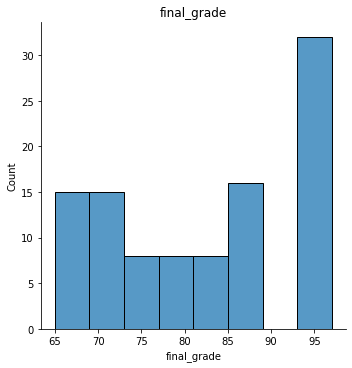

In [18]:
# The default is bins=8.

sns.displot(x='final_grade', data=df)

plt.title('final_grade')
plt.show()

#### `plt.subplot()` & `.hist()`

Here we'll loop through each of the numeric columns of interest and show the distribution of each on a separate subplot. We can use **`enumerate()`** to simplify our code.

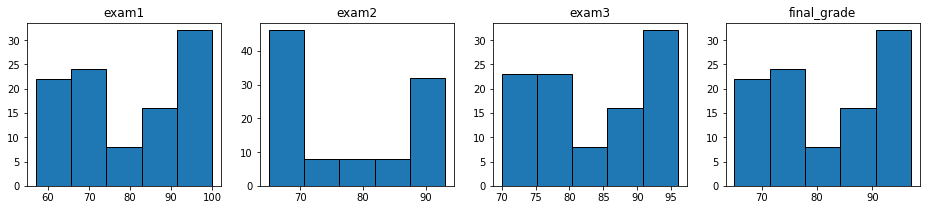

In [19]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['exam1', 'exam2', 'exam3', 'final_grade']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,4, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(bins=5, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

**Mini-Lesson**: What is **`enumerate()`** doing?

In [20]:
# We can loop through an array:
for col in cols:
    print(col)

exam1
exam2
exam3
final_grade


In [21]:
# We can loop through an array while keeping a running count as we do so:
i = 0

for col in cols:
    print(i, col)
    i += 1

0 exam1
1 exam2
2 exam3
3 final_grade


In [22]:
# enumerate() does the same as above in fewer lines of code:
for i, col in enumerate(cols):
    print(i, col)

0 exam1
1 exam2
2 exam3
3 final_grade


#### `sns.boxplot()`

Seaborn's `.boxplot` will default to plotting *all* the numeric variables if we don't specify specific x and y values. 

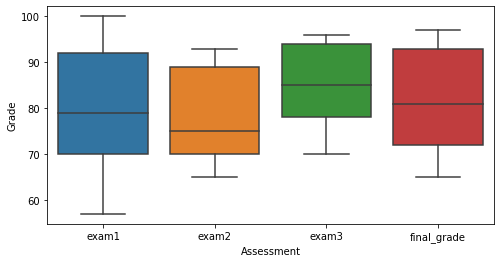

In [23]:
# We don't want to plot the `student_id` column.

plt.figure(figsize=(8,4))

# Create boxplots for all but student_id.
sns.boxplot(data=df.drop(columns=['student_id']))
plt.title('')
plt.ylabel('Grade')
plt.xlabel('Assessment')
plt.show()

#### Distribution Takeaways?

- No obvious outliers
- Exam2 not as normally distributed as the others
- Exam1 has widest range of values
- Exam3 has higher median than others

In [14]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [25]:
df = remove_outliers(df, 1.5, ['exam1', 'exam2', 'exam3'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   student_id   102 non-null    int64
 1   exam1        102 non-null    int64
 2   exam2        102 non-null    int64
 3   exam3        102 non-null    int64
 4   final_grade  102 non-null    int64
dtypes: int64(5)
memory usage: 4.8 KB


___

## Pipeline Function

We finalize these data wrangling steps (acquire and prepare) by writing a function that will reproduce the DataFrame with the necessary changes.

In [27]:
def wrangle_grades(file=file):
    '''
    Read student_grades csv file into a pandas DataFrame,
    drop student_id column, replace whitespaces with NaN values,
    drop any rows with Null values, convert all columns to int64,
    return cleaned student grades DataFrame.
    '''
    # Acquire data from csv file.
    grades = pd.read_csv(file)
    
    # Replace white space values with NaN values.
    grades = grades.replace(r'^\s*$', np.nan, regex=True)
    
    # Drop all rows with NaN values.
    df = grades.dropna()
    
    # Convert all columns to int64 data types.
    df = df.astype('int')
    
    return df

In [28]:
# Let's test out or wrangle function from above.

df = wrangle_grades()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   student_id   102 non-null    int64
 1   exam1        102 non-null    int64
 2   exam2        102 non-null    int64
 3   exam3        102 non-null    int64
 4   final_grade  102 non-null    int64
dtypes: int64(5)
memory usage: 4.8 KB


___

## Exercises I

Let's review the steps we take at the beginning of each new module.

1. Create a new repository named `regression-exercises` in your GitHub; all of your Regression work will be housed here.
1. Clone this repository within your local `codeup-data-science` directory.
1. Create a `.gitignore` and make sure your list of 'files to ignore' includes your `env.py` file.
1. Ceate a `README.md` file that outlines the contents and purpose of your repository.
1. Add, commit, and push these two files.
1. Now you can add your `env.py` file to this repository to access the Codeup database server.
1. For these exercises, you will create `wrangle.ipynb` and `wrangle.py` files to hold necessary functions.
1. As always, add, commit, and push your work often.
---

## Exercises II

Let's set up an example scenario as perspective for our regression exercises using the Zillow dataset.

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

1. Acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the `zillow` database for all 'Single Family Residential' (ID is 261) properties.
- SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
- FROM properties_2017
- WHERE propertylandusetypeid = 261;
1. Using your acquired Zillow data, walk through the summarization and cleaning steps in your `wrangle.ipynb` file like we did above. You may handle the missing values however you feel is appropriate and meaninful; remember to document your process and decisions using markdown and code commenting where helpful.
1. Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe witn no missing values in your `wrangle.py` file. Name your final function `wrangle_zillow`.

In [111]:
sql_query = 'SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips, propertylandusetypeid FROM properties_2017'

In [112]:
df = pd.read_sql(sql_query, f'mysql+pymysql://{user}:{password}@{host}/zillow')

In [113]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
 7   propertylandusetypeid         float64
dtypes: float64(8)
memory usage: 182.2 MB


In [114]:
zillow_df = df[df.propertylandusetypeid == 261.0]

In [115]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152863 entries, 1 to 2982282
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
 7   propertylandusetypeid         float64
dtypes: float64(8)
memory usage: 147.8 MB


In [116]:
zillow_df.propertylandusetypeid.value_counts()

261.0    2152863
Name: propertylandusetypeid, dtype: int64

In [117]:
zillow_df = zillow_df.drop(columns = 'propertylandusetypeid')

In [118]:
zillow_df.shape

(2152863, 7)

In [119]:
zillow_df = zillow_df.dropna()

In [120]:
zillow_df.shape

(2140235, 7)

In [129]:
z_df = zillow_df[(zillow_df.taxvaluedollarcnt < 1200000)]
z_df = z_df[z_df.taxvaluedollarcnt > 10000]
z_df = z_df[z_df.bedroomcnt < 10]
z_df = z_df[z_df.bedroomcnt > 0]
z_df = z_df[z_df.bathroomcnt < 5]
z_df = z_df[z_df.bathroomcnt > 0]

In [130]:
z_df.shape

(2008060, 7)

In [131]:
z_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2008060.0,3.248183,0.866933,1.00,3.00,3.0,4.00,9.00
bathroomcnt,2008060.0,2.115201,0.771061,0.50,2.00,2.0,2.50,4.50
calculatedfinishedsquarefeet,2008060.0,1730.943857,957.833601,1.00,1241.00,1581.0,2086.00,952576.00
taxvaluedollarcnt,2008060.0,359500.049135,239086.327046,10090.00,180937.00,310820.0,486866.00,1199994.00
yearbuilt,2008060.0,1960.128012,21.409969,1801.00,1949.00,1958.0,1973.00,2016.00
taxamount,2008060.0,4459.820709,2785.412570,16.48,2448.04,3914.3,5880.75,100379.34
fips,2008060.0,6048.431311,20.511255,6037.00,6037.00,6037.0,6059.00,6111.00


In [132]:
z_df = round(z_df, 2)
# zillow_df = zillow_df.drop(columns = ['bathroomcnt']).astype('int')

In [133]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2140235.0,3.301419,0.932600,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2140235.0,2.240352,0.990549,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2140235.0,1863.193970,1221.754161,1.00,1258.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2140235.0,460641.625164,677157.635675,22.00,189166.00,328296.00,534606.00,90188462.00
yearbuilt,2140235.0,1960.967545,22.150563,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2140235.0,5616.711322,7814.562798,6.34,2540.85,4111.47,6411.93,1078101.87
fips,2140235.0,6048.309556,20.344910,6037.00,6037.00,6037.00,6059.00,6111.00


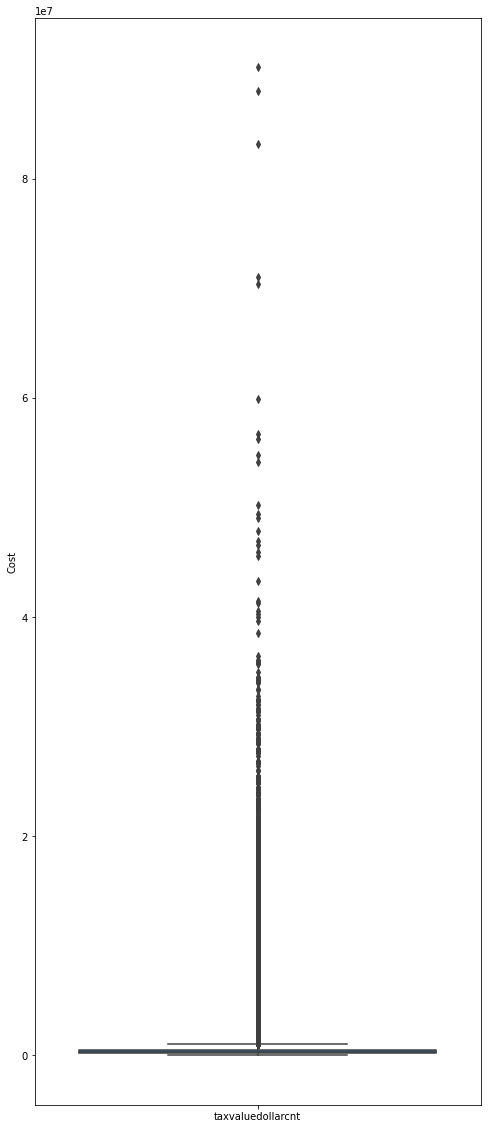

In [58]:
# Max on taxvaluedollarcnt is pretty extreme, look at it w/ box plot.

plt.figure(figsize=(8,20))
sns.boxplot(data=zillow_df.drop(columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount', 'fips', 'propertylandusetypeid']))
plt.title('')
plt.ylabel('Cost')
plt.show()

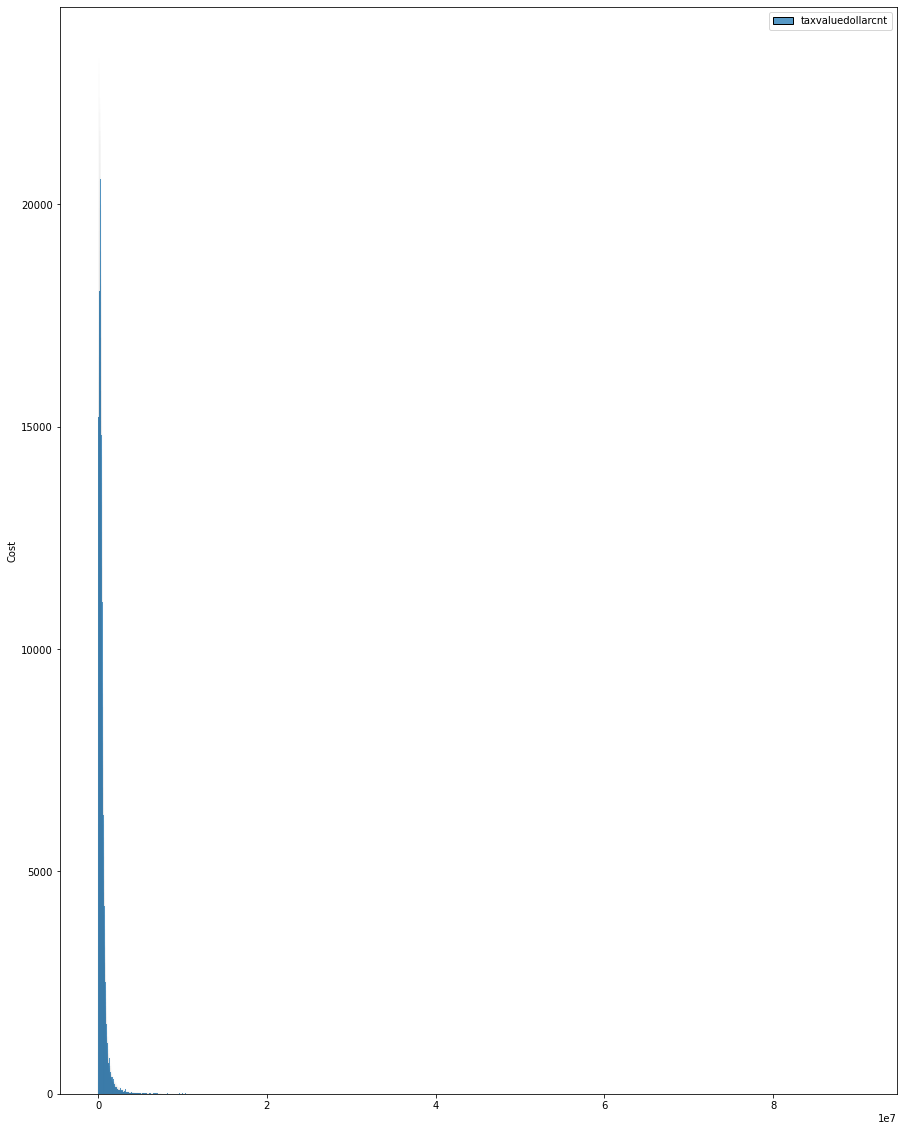

In [59]:
plt.figure(figsize=(15,20))
sns.histplot(data=zillow_df.drop(columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount', 'fips', 'propertylandusetypeid']))
plt.title('')
plt.ylabel('Cost')
plt.show()

In [ ]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [109]:
z_df = remove_outliers(zillow_df, 2, ['taxvaluedollarcnt'])

In [110]:
plt.figure(figsize=(15,20))
sns.histplot(data=z_df.drop(columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount', 'fips']))
plt.title('')
plt.ylabel('Cost')
plt.show()

KeyError: "['bathroomcnt' 'propertylandusetypeid'] not found in axis"

<Figure size 1080x1440 with 0 Axes>

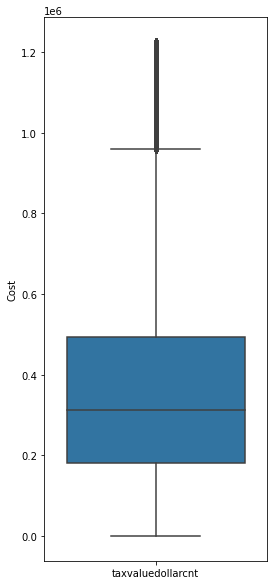

In [62]:
plt.figure(figsize=(4,10))
sns.boxplot(data=z_df.drop(columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount', 'fips', 'propertylandusetypeid']))
plt.title('')
plt.ylabel('Cost')
plt.show()

<Figure size 1080x1440 with 0 Axes>

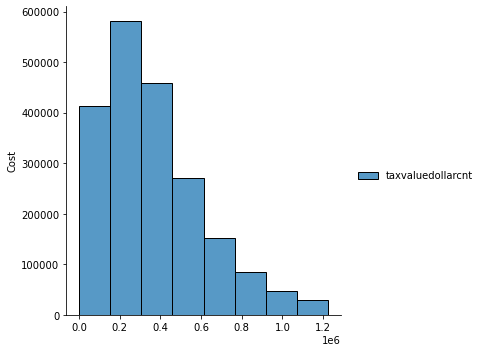

In [63]:
plt.figure(figsize=(15,20))
sns.displot(bins=8, data=z_df.drop(columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount', 'fips', 'propertylandusetypeid']))
plt.title('')
plt.ylabel('Cost')
plt.show()

Text(0.42499999999999716, 0.5, 'Bathrooms')

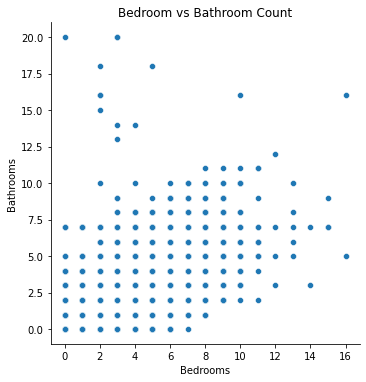

In [76]:
sns.relplot(x='bedroomcnt', y='bathroomcnt', data=z_df)
plt.title('Bedroom vs Bathroom Count')
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')

Text(6.799999999999997, 0.5, 'Bathrooms')

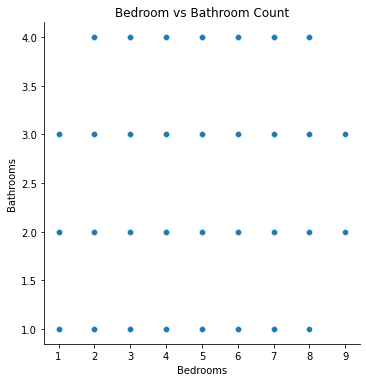

In [84]:
sns.relplot(x='bedroomcnt', y='bathroomcnt', data=z2_df)
plt.title('Bedroom vs Bathroom Count')
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')

<Figure size 1080x1440 with 0 Axes>

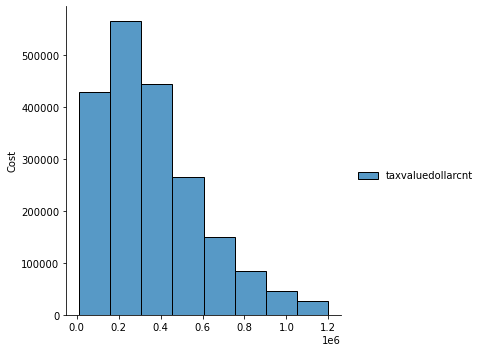

In [99]:
plt.figure(figsize=(15,20))
sns.displot(bins=8, data=z2_df.drop(columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxamount', 'fips', 'propertylandusetypeid']))
plt.title('')
plt.ylabel('Cost')
plt.show()

In [100]:
z2_df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusetypeid
count,2.008048e+06,2.008048e+06,2.008048e+06,2.008048e+06,2.008048e+06,2.008048e+06,2.008048e+06,2008048.0
mean,3.248192e+00,2.064404e+00,1.730949e+03,3.595002e+05,1.960128e+03,4.459329e+03,6.048431e+03,261.0
std,8.669259e-01,7.563025e-01,9.578338e+02,2.390865e+05,2.140985e+01,2.785416e+03,2.051130e+01,0.0
min,1.000000e+00,1.000000e+00,1.000000e+00,1.009000e+04,1.801000e+03,1.600000e+01,6.037000e+03,261.0
25%,3.000000e+00,2.000000e+00,1.241000e+03,1.809370e+05,1.949000e+03,2.448000e+03,6.037000e+03,261.0
50%,3.000000e+00,2.000000e+00,1.581000e+03,3.108200e+05,1.958000e+03,3.914000e+03,6.037000e+03,261.0
75%,4.000000e+00,2.000000e+00,2.086000e+03,4.868660e+05,1.973000e+03,5.880000e+03,6.059000e+03,261.0
max,9.000000e+00,4.000000e+00,9.525760e+05,1.199994e+06,2.016000e+03,1.003790e+05,6.111000e+03,261.0


In [101]:
z2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008048 entries, 20 to 2982282
Data columns (total 8 columns):
 #   Column                        Dtype
---  ------                        -----
 0   bedroomcnt                    int64
 1   bathroomcnt                   int64
 2   calculatedfinishedsquarefeet  int64
 3   taxvaluedollarcnt             int64
 4   yearbuilt                     int64
 5   taxamount                     int64
 6   fips                          int64
 7   propertylandusetypeid         int64
dtypes: int64(8)
memory usage: 137.9 MB
